In [2]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("Set1")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

## 08 1D implicit heat transfer coupled with cure model

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

Just like in lesson 06 we couple the previously devoloped heat transfer solver (the implicit solver in this case) with the cure model from lesson 01. 

## Example: Heat transfer steel RTM tool

<img src="./figures/heat 1d model 03.png" width="500"/>

### Calculate thermal composite properties

In [3]:
# first create steel properties
rho_steel = 7850
c_steel = 475
k_steel = 50

# composite properties
phi = .6
CF = dict(k_f_parallel=10,
          k_f_perp=1.7,
          rho_f=1700,
          c_f=710) 
EP = dict(k_m=.21,
          rho_m=1110,
          c_m=1224)
material_data = {**CF, **EP}

c_f = material_data["c_f"]
rho_f = material_data["rho_f"]
c_m = material_data["c_m"]
rho_m = material_data["rho_m"]
k_f_perp = material_data["k_f_perp"]
k_m = material_data["k_m"]

c_comp = (c_f * rho_f * phi + c_m * rho_m * (1 - phi)) / (rho_f * phi + rho_m * (1 - phi))
print("c_comp =", c_comp)

# k perpendicular to fibers
k_comp = 1 / (phi / k_f_perp * phi + (1 - phi) / k_m)
print("k_comp =", k_comp)

rho_comp = rho_f * phi + rho_m * (1 - phi)
print("rho_comp =", rho_comp)

psi_comp = rho_f * phi / (rho_f * phi + rho_m * (1 - phi))
print("psi_comp =", psi_comp)

c_comp = 865.8852459016393
k_comp = 0.47247220751720487
rho_comp = 1464.0
psi_comp = 0.6967213114754098


### Cure Model

In [4]:
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def reaction_model(X, temp, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    k1, k2 = arrhenius_facors(temp, model_parameters)
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = max_X - X
    d_X[d_X < 0] = 0
    return k1 * d_X**l + k2 * X**m * d_X**n
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])


Hein_2018 = dict(Tg0=-16.8, Tg8=225, lam=.543,    # DiBenedetto
                a=.04, b=3.93,                    # X_max
                A1=np.exp(11.149), EA1=75549,     # Cure model parameters
                A2=np.exp(8.762), EA2=50911, 
                l=.489, m=1.549, n=2.179,
                Hr=490e3                         # Enthalpy [J / kg]
                )
#### Constants
kelvin = 273.15
R = 8.314472

### Discretize space

Nx = 24


<IPython.core.display.Javascript object>


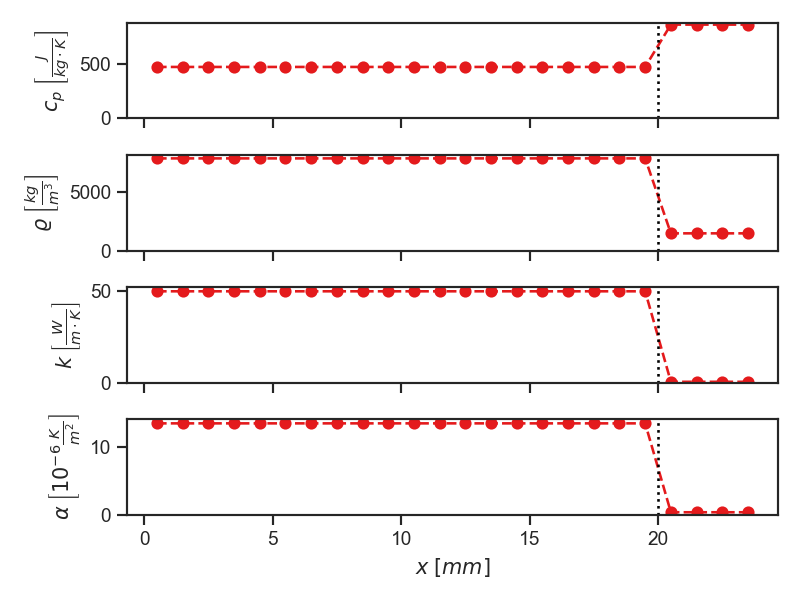

In [5]:
dx = 1/1000
d_mold = 20/1000
d_comp = 4/1000
Nx = int((d_mold + d_comp) / dx)
print("Nx =", Nx)

# shift coordinates half a step (element not material interface)
x = (np.arange(Nx) + .5) * dx  

# make indexes of materials (boolean arrays)
idx_mold = x <= d_mold
idx_comp = x > d_mold

# assign properties
cp = np.zeros(Nx)
cp[idx_mold] = c_steel
cp[idx_comp] = c_comp

rho = np.zeros(Nx)
rho[idx_mold] = rho_steel
rho[idx_comp] = rho_comp

k = np.zeros(Nx)
k[idx_mold] = k_steel
k[idx_comp] = k_comp

# plot model properties
fig, ax = plt.subplots(4, 1, sharex=True)
ax1, ax2, ax3, ax4 = ax

line_kw = dict(marker="o", ls="--")
plt.sca(ax1)
plt.plot(x*1000, cp, **line_kw)
plt.ylabel(r"$c_p \; \left[ \frac{J}{kg \cdot K} \right]$")
plt.sca(ax2)
plt.plot(x*1000, rho, **line_kw)
plt.ylabel(r"$\varrho \; \left[ \frac{kg}{m^3} \right]$")
plt.sca(ax3)
plt.plot(x*1000, k, **line_kw)
plt.ylabel(r"$k \; \left[ \frac{W}{m \cdot K} \right]$")
plt.sca(ax4)
plt.plot(x*1000, k/cp/rho*1e6, **line_kw)
plt.ylabel(r"$\alpha \; \left[ 10^{-6} \frac{K}{m^2} \right]$")
plt.xlabel(r"$x \; [mm]$");

for _ax in ax:
    # plot mold - composite part - interface
    _ax.axvline(d_mold*1000, ls=":", color="k")
    _ax.set_ylim((0, None))
plt.tight_layout()

### Time discretization

In [11]:
# CFL criterion
dt_CFL = dx**2 * np.min(cp * rho / 2 / k)
print("limit for numerical stability: dt =", dt_CFL, "s")
dt = dt_CFL * 10
print("used time step: dt =", dt, "s")

# for the reaction model we use a smaller time step, we introduce a factor
n_cure_iter = 4
# for one heat transfer iteration the cure model will iterate n_cure_iter times

t_max = 3*3600
print("t_max =", t_max)
Nt = int(t_max / dt + 1) 
print("Nt =", Nt)
t = np.arange(Nt) * dt

# Set temperature cycle
T_cure = 160
cycle = [[0, T_cure]]
cycle.append([t_max, T_cure]) 
cycle = np.array(cycle)

limit for numerical stability: dt = 0.0372875 s
used time step: dt = 0.372875 s
t_max = 10800
Nt = 28965


### Implicit Model and helper funftions

*Function calc_A_matrix() has been adapted to sigma in array form (heterogeneous sigma), before it only worked for single values (homogeneous sigma over space)*

In [7]:
from scipy import linalg
def calc_A_matrix(N, sigma):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    # Setup the diagonal of the operator.
    D = np.diag((2 + 1 / sigma))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1 + 1 / sigma[-1]
    # Setup the upper diagonal of the operator.
    U = np.diag(-1 * np.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = np.diag(-1 * np.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A
def calc_b_vector(T, sigma, qdx=0):
    """
    Compute vector b + b_bc for 1D model with dirichlet BC on left and 
    Neumann BC (heat flux qdx) on right side
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b
def implicit1D_nofluxright(T, sigma, A):
    """
    Solve implicit matrix formulation, pass matrix A (only calculate once)
    """
    # Generate the right-hand side of the system.
    b = calc_b_vector(T, sigma, 0)
    # Solve the system with scipy.linalg.solve.
    T[1:-1] = linalg.solve(A, b)
    # Apply the Neumann boundary condition.
    T[-1] = T[-2] 
    return T

### Simulate!

i_snap = 2


<IPython.core.display.Javascript object>


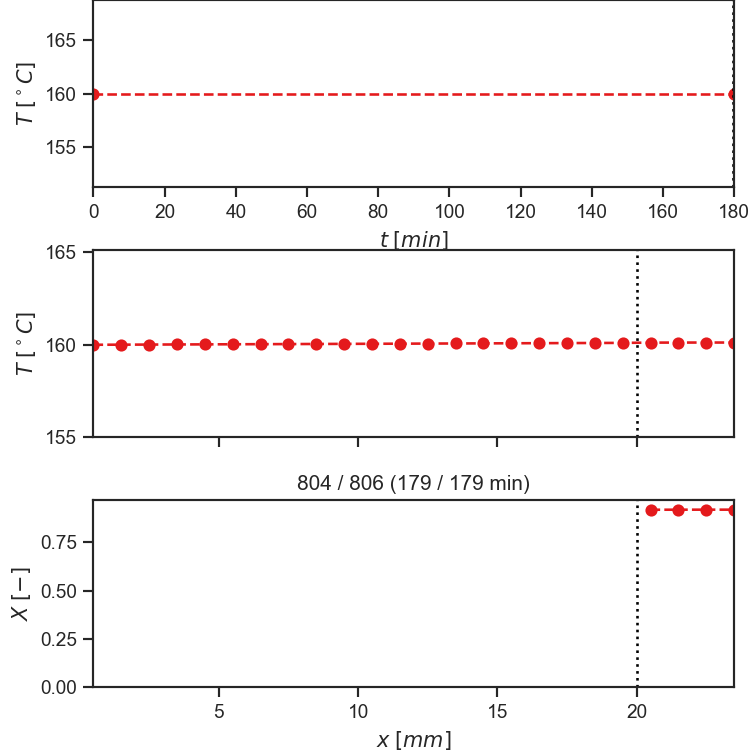

In [8]:
# Set initial conditions
T = np.zeros(Nx)
T[:] = cycle[0, 1]

# degree of cure
X = np.zeros(np.sum(idx_comp))

# choose how often to update plot
i_snap = Nt // 300
print("i_snap =", i_snap)

### prepare output arrays
# 1st column: max temp and X in composite
# 2nd column: min temp and X in composite
# 3rd column: temp and X at mold interface of composite
# 4th column: temp and X at middle of composite (border of simulation)
T_out = np.zeros((Nt, 4))
X_out = np.zeros((Nt, 4))

# prepare plot
fig, ax = plt.subplots(3, 1, figsize=[6, 6])
ax1, ax2, ax3 = ax

plt.sca(ax1)
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1], **line_kw)
p_cycle = plt.axvline(cycle[0, 0]/60, ls=":", color="k")

plt.sca(ax2)
plt.ylabel(r"$T \; [ ^\circ C ]$")
p_temp, = plt.plot(x*1000, T, **line_kw)

plt.sca(ax3)
plt.ylabel(r"$X \; [ - ]$")
p_cure, = plt.plot(x[idx_comp]*1000, X, **line_kw)
plt.xlabel(r"$x \; [mm]$")
for _ax in ax[1:]:
    # plot mold - composite part - interface    
    _ax.axvline(d_mold*1000, ls=":", color="k")
    
ax1.autoscale(axis="x", tight=True)
ax2.autoscale(axis="x", tight=True)
ax3.set_xlim(ax2.get_xlim())
ax2.set_xticklabels([])

plt.tight_layout(pad=0)
plt.ion();

In [9]:
sigma = k[1:-1] / rho[1:-1] / cp[1:-1] * dt / dx**2
A = calc_A_matrix(Nx-2, sigma)

for n in range(Nt):
    # Left Boundary: set value from temperate cycle 
    T[0] = interpol_tempcycle(t[n], cycle)
    
    # calculate heat transfer
    T = implicit1D_nofluxright(T, sigma, A)
    
    for n_cure in range(n_cure_iter):
        # reaction rate
        dXdt = reaction_model(X, T[idx_comp], Hein_2018)
        # update degree of cure
        X += dXdt*dt/n_cure_iter

        # released heat
        q = dXdt*dt/n_cure_iter*Hein_2018["Hr"]*(1-psi_comp)    
        T[idx_comp] += q/cp[idx_comp]
    
    # right boundary condition (no heat flux)
    T[-1] = T[-2]
    
    # write output
    T_out[n, 0] = T[idx_comp].max()
    T_out[n, 1] = T[idx_comp].min()
    T_out[n, 2] = T[idx_comp][0]
    T_out[n, 3] = T[idx_comp][-1]
    X_out[n, 0] = X.max()
    X_out[n, 1] = X.min()
    X_out[n, 2] = X[0]
    X_out[n, 3] = X[-1]    
    
    # update plot
    if n % i_snap == 0:
        ax3.set_title("%d / %d (%d / %d min)" %(n, Nt, t[n]/60, t[-1]/60))
        p_cycle.set_xdata(t[n]/60)
        p_temp.set_ydata(T)
        p_cure.set_ydata(X)      
        ax2.set_ylim((T.min()-5, T.max()+5))
        ax3.set_ylim((0, X.max()+.05))
        fig.canvas.draw()

### Postprocessing

T_max = 176.42608061524226


<IPython.core.display.Javascript object>


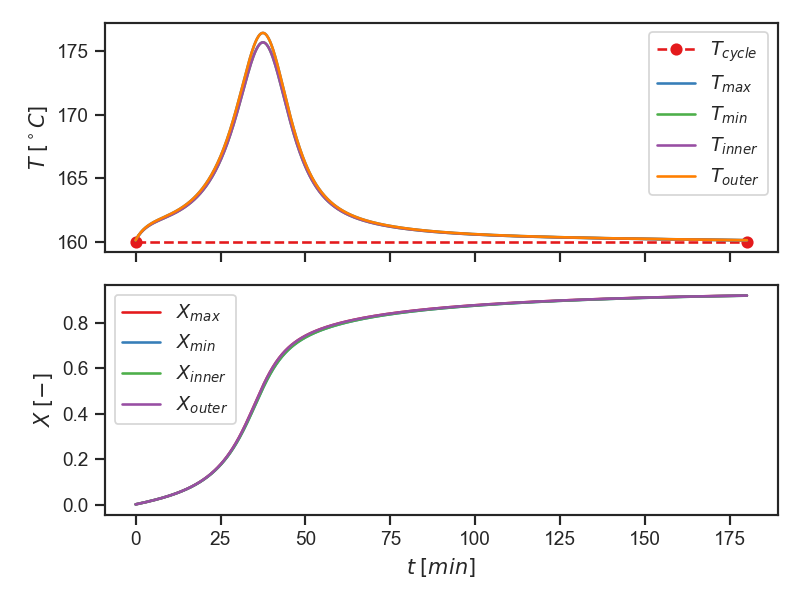

In [10]:
print("T_max =", T_out[:, 0].max())

fig, ax = plt.subplots(2, 1, sharex=True)
ax1, ax2 = ax
ax1.plot(cycle[:, 0]/60, cycle[:, 1], "o--", label=r"$T_{cycle}$")

for i, _label in enumerate(["max", "min", "inner", "outer"]):
    plt.sca(ax1)
    label = r"$T_{%s}$" %_label
    plt.plot(t/60, T_out[:, i], label=label)
    plt.sca(ax2)
    label = r"$X_{%s}$" %_label
    plt.plot(t/60, X_out[:, i], label=label)

for _ax in ax:
    _ax.legend()

ax1.set_ylabel(r"$T \; [ ^\circ C ]$")
ax2.set_ylabel(r"$X \; [ - ]$")
ax2.set_xlabel(r"$t \; [min]$")
plt.tight_layout();